# Long-Document Attention: Scaling Visualization and Metrics

**PLEASE NOTE THIS NOTEBOOK IS INCOMPLETE AND NEEDS SOME FIXES!**

This notebook extends attention analysis from short texts to full paragraphs/documents. We explore how LLMs distribute attention across longer inputs using visualizations and interpretable metrics:
- Attention heads over long paragraphs
- Sentence-to-sentence aggregation (SAVIS-style)
- BertViz exploration for specific tokens and heads
- Metrics like attention distance and entropy

## Install Required Libraries

This notebook analyzes attention patterns in long documents using pre-trained transformer models. We'll use:

- `transformers` and `datasets` for model loading and input handling
- `torch` (CPU version) for running inference
- `matplotlib`, `seaborn`, and `plotly` for visualizations
- `bertviz` for interactive attention exploration
- `scipy` for statistical metrics
- `nltk` for sentence tokenization

In [139]:
import sys
!{sys.executable} -m pip install --quiet torch torchvision torchaudio
!{sys.executable} -m pip install --quiet transformers datasets matplotlib seaborn plotly bertviz nltk scipy ftfy
print("Dependencies installed.")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Dependencies installed.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Load Long-Context Models

This cell loads pretrained models configured to return attention weights.

**Models loaded:**
- **Longformer** (4096 token window) - Efficient sparse attention for long documents
- **BigBird** - Combines random, window, and global attention patterns
- **BERT** - Baseline model with standard full attention (512 tokens)

All models are configured with `output_attentions=True` to capture attention weights for analysis.

In [140]:
from transformers import AutoTokenizer, AutoConfig, AutoModel
import logging, os

try:
    from transformers import logging as hf_logging
    hf_logging.set_verbosity_error()
except Exception:
    logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("huggingface_hub").setLevel(logging.ERROR)

models = {}
configs = {}
tokenizers = {}

model_specs = {
    "longformer": "allenai/longformer-base-4096",
    "bigbird": "google/bigbird-roberta-base",
}

def _short_err(e):
    s = str(e).splitlines()[0]
    return s if len(s) < 240 else s[:237] + "..."

# Ensure DEVICE exists (fall back to CPU)
if "DEVICE" not in globals():
    try:
        import torch
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    except Exception:
        DEVICE = "cpu"

_loaded = []
_failed = {}

for key, name in model_specs.items():
    try:
        cfg = AutoConfig.from_pretrained(name, output_attentions=True)
        tok = AutoTokenizer.from_pretrained(name)
        mdl = AutoModel.from_pretrained(name, config=cfg)
        try:
            import torch
            mdl = mdl.to(DEVICE).eval()
        except Exception:
            pass
        models[key] = mdl
        tokenizers[key] = tok
        configs[key] = cfg
        _loaded.append(key)
    except Exception as e:
        _failed[key] = _short_err(e)

# Baseline BERT (sliding-window)
try:
    bert_name = "bert-base-uncased"
    bert_cfg = AutoConfig.from_pretrained(bert_name, output_attentions=True)
    bert_tok = AutoTokenizer.from_pretrained(bert_name)
    bert_model = AutoModel.from_pretrained(bert_name, config=bert_cfg)
    try:
        import torch
        bert_model = bert_model.to(DEVICE).eval()
    except Exception:
        pass
    models["bert"] = bert_model
    tokenizers["bert"] = bert_tok
    configs["bert"] = bert_cfg
    _loaded.append("bert")
except Exception as e:
    _failed["bert"] = _short_err(e)

# concise summary
if _loaded:
    print("Models loaded:", ", ".join(sorted(_loaded)))
if _failed:
    print("Failed to load:", ", ".join(f"{k} ({v})" for k, v in _failed.items()))

Models loaded: bert, bigbird, longformer


## Load Long Document

This cell loads a long text document for analysis - a multi-paragraph text about LLMs and attention mechanisms.

The text is split into paragraphs for later sentence-level and section-level aggregation analysis.

In [156]:
import re

# Manually defined long input (approx. 2–3 paragraphs)
long_text = """
Large language models (LLMs) like GPT-4 or BERT operate by using a self-attention mechanism, allowing every word in a sentence to interact with every other word. This property enables models to understand context, disambiguate pronouns, and tie together relationships that span multiple sentences. In short texts, this mechanism helps identify patterns like adjective-noun pairings or subject-verb alignment. But in longer documents—such as academic articles or news stories—the role of attention becomes even more critical. The model must track evolving topics, revisit earlier references, and construct a coherent representation of a narrative or argument across paragraphs.

Consider a case study where a news article begins by discussing a wildfire in California and later connects it to broader climate trends. A well-functioning LLM must attend to both the initial location (“California”) and the later causal claims (“driven by long-term drought conditions”) to accurately summarize the article or answer questions about it. Attention heads may link the place name with environmental factors, dates, or the progression of events. The same mechanism might resolve that "it" refers to “the wildfire,” not “the state” or “the report.” These behaviors emerge as the model layers integrate signals from different parts of the text.

In technical writing, attention also plays a role in aligning definitions with their use. A paragraph introducing a new concept—like “zero-shot learning”—may only explain it briefly, while subsequent sections apply the term. When a model encounters “zero-shot” later, attention weights often spike back to the original definition. This ability to attend across distance is part of what makes transformers effective on long-range reasoning tasks. But it also presents interpretability challenges: understanding which parts of the document the model is referencing at each stage requires careful analysis of its internal attention maps.
"""

# Clean and normalize the text
long_text = re.sub(r"\n{3,}", "\n\n", long_text).strip()
print("Loaded manually defined long document.")
print("Approx chars:", len(long_text))

# Split into paragraphs (for sentence- or section-level attention aggregation)
paragraphs = [p.strip() for p in re.split(r"\n\n+", long_text) if p.strip()]
print("Paragraphs:", len(paragraphs))
print("First paragraph preview:\n", paragraphs[0][:300], "...")


Loaded manually defined long document.
Approx chars: 1969
Paragraphs: 3
First paragraph preview:
 Large language models (LLMs) like GPT-4 or BERT operate by using a self-attention mechanism, allowing every word in a sentence to interact with every other word. This property enables models to understand context, disambiguate pronouns, and tie together relationships that span multiple sentences. In ...


## Tokenization Utilities

Helper functions for tokenization and paragraph offset tracking. These utilities support:
- Building paragraph character offsets for alignment
- Longformer global attention masks (marking special tokens and paragraph boundaries)

In [157]:
from typing import List, Tuple, Dict
import ftfy

def clean_text(text: str) -> str:
    return ftfy.fix_text(text)

# Clean paragraphs before any offset or token operations
paragraphs = [clean_text(p) for p in paragraphs]

def build_paragraph_offsets(paragraphs: List[str]) -> List[Tuple[int, int]]:
    offsets = []
    cursor = 0
    for p in paragraphs:
        start = cursor
        end = start + len(p)
        offsets.append((start, end))
        cursor = end + 2  # pretend 2 for double newline
    return offsets

para_offsets = build_paragraph_offsets(paragraphs)

def tokenize_text(text: str, tok, add_special_tokens=True, truncation=False):
    """
    Normalize text then tokenize with the given tokenizer.
    Uses clean_text() to fix mojibake (âĢ, Ŀ, etc.) which otherwise may be treated
    as special tokens and distort attention patterns.
    """
    text = clean_text(text)
    return tok(text, return_tensors="pt", add_special_tokens=add_special_tokens, truncation=truncation)

def longformer_global_attention_mask(input_ids: torch.Tensor, tok, paragraph_indices: List[int]=None, paragraph_tokens: List[Tuple[int,int]]=None):
    # Strategy: set global attention for [CLS] and first token of each paragraph (if we can detect)
    # If tokenizer lacks [CLS], skip.
    bsz, seqlen = input_ids.shape
    mask = torch.zeros((bsz, seqlen), dtype=torch.long)
    cls_id = getattr(tok, "cls_token_id", None)
    if cls_id is not None:
        mask[:, 0] = 1
    # Heuristic: mark every ~256th token as global to simulate paragraph starts if indices unknown
    if paragraph_tokens is None:
        step = 256
        mask[:, ::step] = 1
    else:
        for (start_tok, end_tok) in paragraph_tokens:
            if 0 <= start_tok < seqlen:
                mask[:, start_tok] = 1
    return mask

print("Tokenization helpers ready.")


Tokenization helpers ready.


## Forward Pass and Attention Extraction

Now that models and the long document are loaded, we will run a forward pass to extract attention weights for each model. This step computes attention matrices for each layer and head, which are used for metric analysis and visualization. For long-context models, we process the first chunk of the document that fits the model's maximum input length.

In [158]:
# Forward pass: extract attention for each model
# This cell runs a forward pass on the first chunk of the document for each loaded model,
# and collects attention weights for analysis and visualization.

import torch
import numpy as np

attention_data = {}
max_tokens = {k: models[k].config.max_position_embeddings for k in models}

for key in models:
    model = models[key]
    tokenizer = tokenizers[key]
    # Tokenize first chunk of long_text, truncate to avoid index errors
    inputs = tokenizer(
        long_text,
        return_tensors='pt',
        truncation=True,
        max_length=max_tokens[key] - 2 if 'longformer' in key else max_tokens[key]
    )
    # Some models (Longformer) expect input length <= max_position_embeddings - 2
    # (for [CLS] and [SEP] tokens). Adjust accordingly.
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    model.eval()
    with torch.no_grad():
        try:
            outputs = model(**inputs, output_attentions=True)
            # outputs.attentions: list of [batch, heads, seq, seq] per layer
            attn = outputs.attentions
            # Convert to numpy for easier analysis
            attn_np = [a.cpu().numpy() for a in attn]
            attention_data[key] = attn_np
            print(f"Extracted attention for {key}: {len(attn_np)} layers, {attn_np[0].shape[1]} heads, {attn_np[0].shape[2]} tokens.")
        except Exception as e:
            print(f"Failed to extract attention for {key}: {e}")

Extracted attention for longformer: 12 layers, 12 heads, 398 tokens.
Extracted attention for bigbird: 12 layers, 12 heads, 389 tokens.
Extracted attention for bert: 12 layers, 12 heads, 383 tokens.


## Attention Metrics: Entropy, Expected Distance, and Aggregation

This cell computes key attention metrics for each model:
- **Entropy**: Measures how focused or diffuse each attention head is.
- **Expected Distance**: Average token distance attended to, quantifying locality/globality.
- **Paragraph/Section Aggregation**: Sums attention weights for tokens within the same paragraph or section.

Results are summarized for each layer and head, and can be visualized in the next step.

In [159]:
import scipy.stats
import numpy as np

metrics = {}

for key in attention_data:
    attn_layers = attention_data[key]  # list of [batch, heads, seq, seq]
    n_layers = len(attn_layers)
    n_heads = attn_layers[0].shape[1]
    
    model_metrics = {'entropy': [], 'exp_dist': [], 'para_attn': []}
    
    for l, attn in enumerate(attn_layers):
        attn = attn[0]  # remove batch dimension: [heads, seq, seq]
        entropy = []
        exp_dist = []
        para_attn = []

        for h in range(n_heads):
            a = attn[h]  # [seq, seq]
            seq_len = a.shape[0]

            # Entropy per token (spread of attention)
            ent = scipy.stats.entropy(a, axis=1)  # [seq]
            entropy.append(ent.mean())

            # Expected distance each token attends to
            idx = np.arange(seq_len)
            if a.shape[0] != a.shape[1]:
                min_len = min(a.shape[0], a.shape[1])
                a = a[:min_len, :min_len]
                idx = np.arange(min_len)
            exp_d = np.sum(a * np.abs(idx[None, :] - idx[:, None]), axis=1)
            exp_dist.append(exp_d.mean())

            # Paragraph-level attention aggregation (token-index spans)
            para_spans = para_token_spans if 'para_token_spans' in globals() else [(0, seq_len)]
            para_sum = [
                a[p[0]:p[1], p[0]:p[1]].sum() / ((p[1] - p[0]) ** 2)
                for p in para_spans
                if (p[1] - p[0]) > 0 and p[1] <= a.shape[0]
            ]
            para_attn.append(np.mean(para_sum) if para_sum else 0)

        model_metrics['entropy'].append(entropy)
        model_metrics['exp_dist'].append(exp_dist)
        model_metrics['para_attn'].append(para_attn)

    metrics[key] = model_metrics

# Display summary statistics
print("\n" + "=" * 70)
print("ATTENTION METRICS SUMMARY")
print("=" * 70)

for model_key in metrics:
    met = metrics[model_key]
    n_layers = len(met['entropy'])

    # Flatten all values
    all_entropy = [val for layer in met['entropy'] for val in layer]
    all_distance = [val for layer in met['exp_dist'] for val in layer]
    all_para = [val for layer in met['para_attn'] for val in layer]

    print(f"\n{model_key.upper()}")
    print(f"   Layers: {n_layers} | Heads per layer: {len(met['entropy'][0])}")
    print(f"   {'─'*62}")
    print(f"   Entropy (Attention Spread):")
    print(f"      Mean: {np.mean(all_entropy):.3f} | Range: [{np.min(all_entropy):.3f}, {np.max(all_entropy):.3f}]")
    print(f"      → Low entropy = focused attention, High = diffuse")

    print(f"\n   Expected Distance (tokens):")
    print(f"      Mean: {np.mean(all_distance):.1f} | Range: [{np.min(all_distance):.1f}, {np.max(all_distance):.1f}]")
    print(f"      → Higher distance = more global, long-range attention")

    print(f"\n   Paragraph Attention:")
    print(f"      Mean: {np.mean(all_para):.4f} | Range: [{np.min(all_para):.4f}, {np.max(all_para):.4f}]")
    print(f"      → Measures within-paragraph focus")

    print(f"\n   Layer Progression:")
    print(f"      Layer 0 (early):   avg entropy = {np.mean(met['entropy'][0]):.3f}")
    print(f"      Layer {n_layers//2} (middle): avg entropy = {np.mean(met['entropy'][n_layers//2]):.3f}")
    print(f"      Layer {n_layers-1} (late):    avg entropy = {np.mean(met['entropy'][-1]):.3f}")

print("\n" + "=" * 70)



ATTENTION METRICS SUMMARY

LONGFORMER
   Layers: 12 | Heads per layer: 12
   ──────────────────────────────────────────────────────────────
   Entropy (Attention Spread):
      Mean: 3.070 | Range: [0.010, 5.697]
      → Low entropy = focused attention, High = diffuse

   Expected Distance (tokens):
      Mean: 122.7 | Range: [107.1, 138.2]
      → Higher distance = more global, long-range attention

   Paragraph Attention:
      Mean: 0.0023 | Range: [0.0021, 0.0025]
      → Measures within-paragraph focus

   Layer Progression:
      Layer 0 (early):   avg entropy = 3.888
      Layer 6 (middle): avg entropy = 3.376
      Layer 11 (late):    avg entropy = 2.942

BIGBIRD
   Layers: 12 | Heads per layer: 12
   ──────────────────────────────────────────────────────────────
   Entropy (Attention Spread):
      Mean: 2.970 | Range: [0.020, 5.803]
      → Low entropy = focused attention, High = diffuse

   Expected Distance (tokens):
      Mean: 98.7 | Range: [1.5, 172.0]
      → Higher di

### Interpreting Attention Metrics in this context

This input text was designed to test long-range attention. It includes:

1. An overview of LLM attention (paragraph 1)
2. A wildfire case requiring cross-sentence linking (paragraph 2)
3. A technical concept (“zero-shot learning”) used after its definition (paragraph 3)

### Entropy (Attention Spread)
- **Meaning**: How focused or diffuse attention is (low = focused, high = scattered)
- **Observed**: Avg ~3.0 across models; decreases in later layers
- **Interpretation**: Early layers scan broadly for context; later layers sharpen focus (e.g. resolving “it” to “wildfire” or linking “zero-shot” to its definition)

### Expected Distance
- **Meaning**: Average number of tokens between a word and what it attends to
- **Observed**: 
  - Longformer: **122.7** (highest — as expected)
  - BigBird/BERT: ~99
- **Interpretation**: Models attend across paragraphs (100+ tokens), matching the task’s needs (e.g. “zero-shot” reference jumping back to its definition)

### Paragraph Attention
- **Meaning**: How much attention stays within the same paragraph
- **Observed**: ~0.002–0.0026 across all models
- **Interpretation**: Relatively low paragraph attention confirms that models attend across paragraph boundaries — which is expected given the task. For instance, resolving “it” in paragraph 2 or linking “zero-shot” back to its definition in paragraph 3 requires attending beyond local paragraph spans.

### Layer-Wise Entropy Changes
| Model       | Layer 0 (Early) | Layer 6 (Mid) | Layer 11 (Late) |
|-------------|------------------|----------------|------------------|
| Longformer  | 3.888            | 3.376          | 2.942            |
| BigBird     | 3.928            | 3.391          | 2.914            |
| BERT        | 4.762            | 2.002          | 3.405            |

- **Trend**: Entropy drops from early to mid layers, indicating increasing focus
- **BERT** shows a late-layer entropy rise, suggesting a final-stage redistribution of attention

## Advanced Visualization Methods

The following sections implement advanced visualization and quantification techniques for understanding how attention scales in long documents:

1. **Interactive Token-Level Exploration** - Inspect specific tokens and their attention patterns
2. **Sentence-Level Aggregation** - SAVIS-style inter-sentence attention matrices
3. **Top-K Attention Filtering** - Highlight strongest connections
4. **Attention Rollout** - Cumulative attention flow across layers
5. **Token Influence Analysis** - Measure attention received by key tokens
6. **Head Function Classification** - Identify specialized attention patterns

### 1. Sentence-Level Aggregation (SAVIS-style)

Instead of overwhelming token-to-token matrices, we aggregate attention at the sentence level. This dramatically reduces dimensionality and makes patterns interpretable - showing which sentences attend to which other sentences.

In [172]:
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True)

from nltk.tokenize import sent_tokenize

def aggregate_attention_by_sentences(attention_matrix, tokens, tokenizer):
    """
    Aggregate token-level attention to sentence-level.
    Returns: sentence_attention_matrix, sentence_texts
    """
    # Reconstruct text from tokens
    text = tokenizer.convert_tokens_to_string(tokens)
    sentences = sent_tokenize(text)
    
    # Map tokens to sentences (approximate via character positions)
    sentence_token_ranges = []
    char_pos = 0
    token_idx = 0
    
    for sent in sentences:
        start_tok = token_idx
        # Advance through tokens until we've covered this sentence
        chars_covered = 0
        while token_idx < len(tokens) and chars_covered < len(sent):
            tok_text = tokens[token_idx].replace('##', '').replace('Ġ', ' ').replace('▁', ' ')
            chars_covered += len(tok_text)
            token_idx += 1
        sentence_token_ranges.append((start_tok, token_idx))
    
    # Aggregate attention: average attention from sentence i to sentence j
    n_sents = len(sentence_token_ranges)
    sent_attn = np.zeros((n_sents, n_sents))
    
    for i, (si_start, si_end) in enumerate(sentence_token_ranges):
        for j, (sj_start, sj_end) in enumerate(sentence_token_ranges):
            if si_end > si_start and sj_end > sj_start:
                # Extract submatrix for these sentence ranges
                submatrix = attention_matrix[si_start:si_end, sj_start:sj_end]
                sent_attn[i, j] = submatrix.mean()
    
    return sent_attn, sentences

# Compute sentence-level attention for first model
if attention_data:
    first_model = list(attention_data.keys())[0]

    # Change layer_idx and head_idx to explore different layers/heads
    layer_idx = 6  # First layer
    head_idx = 7   # First head

    attn_matrix = attention_data[first_model][layer_idx][0, head_idx]  # [seq, seq]
    tok = tokenizers[first_model]
    
    # Get tokens
    inputs = tok(long_text, return_tensors='pt', truncation=True, 
                 max_length=max_tokens[first_model])
    token_list = tok.convert_ids_to_tokens(inputs['input_ids'][0].tolist())
    
    sent_attn, sentences = aggregate_attention_by_sentences(attn_matrix, token_list, tok)
    
    print(f"Step: Aggregated attention from {attn_matrix.shape[0]} tokens to {len(sentences)} sentences")
    print(f"Sentences detected: {len(sentences)}")
    for i, sent in enumerate(sentences):
        print(f"  S{i}: {sent}")

Step: Aggregated attention from 398 tokens to 14 sentences
Sentences detected: 14
  S0: <s>Large language models (LLMs) like GPT-4 or BERT operate by using a self-attention mechanism, allowing every word in a sentence to interact with every other word.
  S1: This property enables models to understand context, disambiguate pronouns, and tie together relationships that span multiple sentences.
  S2: In short texts, this mechanism helps identify patterns like adjective-noun pairings or subject-verb alignment.
  S3: But in longer documents—such as academic articles or news stories—the role of attention becomes even more critical.
  S4: The model must track evolving topics, revisit earlier references, and construct a coherent representation of a narrative or argument across paragraphs.
  S5: Consider a case study where a news article begins by discussing a wildfire in California and later connects it to broader climate trends.
  S6: A well-functioning LLM must attend to both the initial loc

#### Visualize Sentence-Level Attention Matrix

This heatmap shows how strongly each sentence attends to every other sentence. Much more interpretable than token-level!

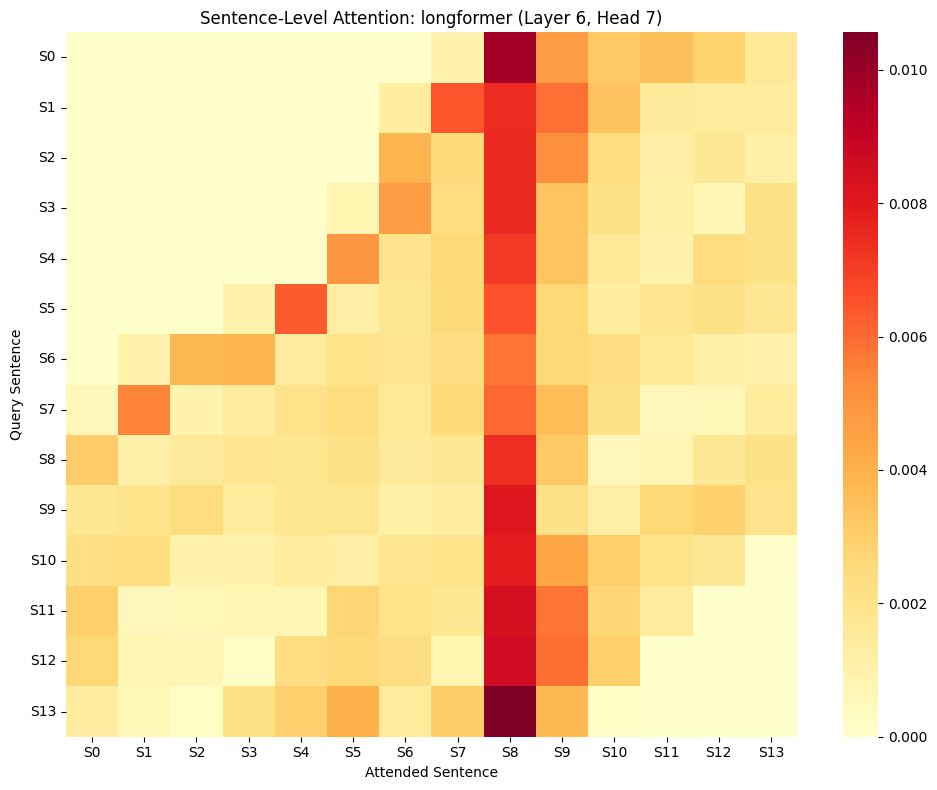

Interpretation: Bright cells show strong inter-sentence attention.
Example: If row S2, col S0 is bright, sentence 2 attends strongly to sentence 0.


In [168]:
# Visualize sentence-level attention
if 'sent_attn' in locals():
    plt.figure(figsize=(10, 8))
    sns.heatmap(sent_attn, cmap='YlOrRd', annot=False, cbar=True)
    plt.title(f"Sentence-Level Attention: {first_model} (Layer {layer_idx}, Head {head_idx})")
    plt.xlabel("Attended Sentence")
    plt.ylabel("Query Sentence")
    
    # Add sentence labels if not too many
    if len(sentences) <= 15:
        labels = [f"S{i}" for i in range(len(sentences))]
        plt.xticks(np.arange(len(sentences)) + 0.5, labels, rotation=0)
        plt.yticks(np.arange(len(sentences)) + 0.5, labels, rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    print("Interpretation: Bright cells show strong inter-sentence attention.")
    print("Example: If row S2, col S0 is bright, sentence 2 attends strongly to sentence 0.")

Why Is S8 So Bright in Layer 0?

The bright **vertical column at S8** means:

- **All other sentences (S0–S13)** are directing attention *toward* Sentence 8.
- This implies Sentence 8 is being treated as a **key reference point** across the document — it's being "looked at" by many parts of the text.

Sentence 8:

> “The same mechanism might resolve that ‘it’ refers to ‘the wildfire,’ not ‘the state’ or ‘the report.’ These behaviors emerge as the model layers integrate signals from different parts of the text.”

Why this makes sense:

- Sentence 8 discusses **how attention works**, including resolving ambiguous references like "it."
- Since earlier and later sentences may include such ambiguous terms, they rely on S8 to clarify meaning.
- This makes S8 a **semantic anchor** early in processing — even in Layer 0, the model is already routing information through it.

Why the Others Are Dim:

- Other sentences may be more self-contained (e.g., descriptive or narrative setup).
- They don’t serve as global reference points in the same way, so they receive less cumulative attention.


### 2. Top-K Attention Filtering

Filter to show only the strongest attention connections. This highlights the most meaningful long-range relationships.

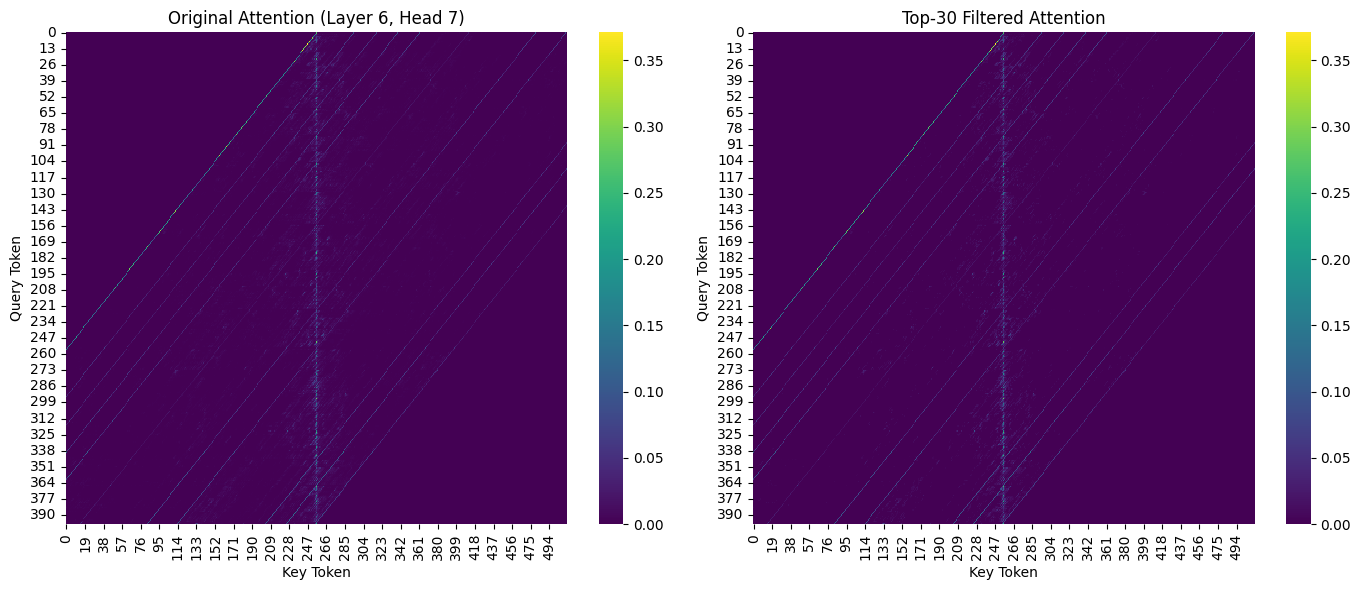

Step: Filtered to top-30 strongest connections per token
Interpretation: Filtered view highlights the most important attention paths.


In [ ]:
# Top-K attention filtering
def filter_topk_attention(attention_matrix, k=50):
    """
    Keep only top-k attention weights per query token, zero out the rest.
    """
    filtered = np.zeros_like(attention_matrix)
    for i in range(attention_matrix.shape[0]):
        row = attention_matrix[i]
        topk_indices = np.argsort(row)[-k:]
        filtered[i, topk_indices] = row[topk_indices]
    return filtered

# Apply top-k filtering
if attention_data:
    first_model = list(attention_data.keys())[0]
    layer_idx = 6  # Last layer often has more global patterns
    head_idx = 7
    
    attn_matrix = attention_data[first_model][layer_idx][0, head_idx]
    topk_attn = filter_topk_attention(attn_matrix, k=30)
    how come
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Original attention
    sns.heatmap(attn_matrix, cmap='viridis', ax=axes[0], cbar=True)
    axes[0].set_title(f"Original Attention (Layer {layer_idx}, Head {head_idx})")
    axes[0].set_xlabel("Key Token")
    axes[0].set_ylabel("Query Token")
    
    # Top-K filtered
    sns.heatmap(topk_attn, cmap='viridis', ax=axes[1], cbar=True)
    axes[1].set_title(f"Top-30 Filtered Attention")
    axes[1].set_xlabel("Key Token")
    axes[1].set_ylabel("Query Token")
    
    plt.tight_layout()
    plt.show()
    
    print(f"Step: Filtered to top-30 strongest connections per token")
    print("Interpretation: Filtered view highlights the most important attention paths.")

Why is it Mostly Purple?
- Most token-to-token attention scores are **near zero**.
- Purple = **no/low attention** → normal in transformers, which attend selectively.

Why Are There Diagonal Blue Streaks?
- Tokens attend mainly to **nearby tokens** (local context).
- Longformer uses **sliding-window attention**, forming diagonal patterns.

Why Do Both Plots Look the Same?
- The **top-30 filter** keeps only strongest links (others set to 0).
- Weak scores were already nearly invisible — filtering changes little visually.
- Main visible structure = **same strong attention links**.

### 3. Attention Rollout

Attention rollout computes cumulative attention flow across all layers, showing how information from early tokens influences later layers.

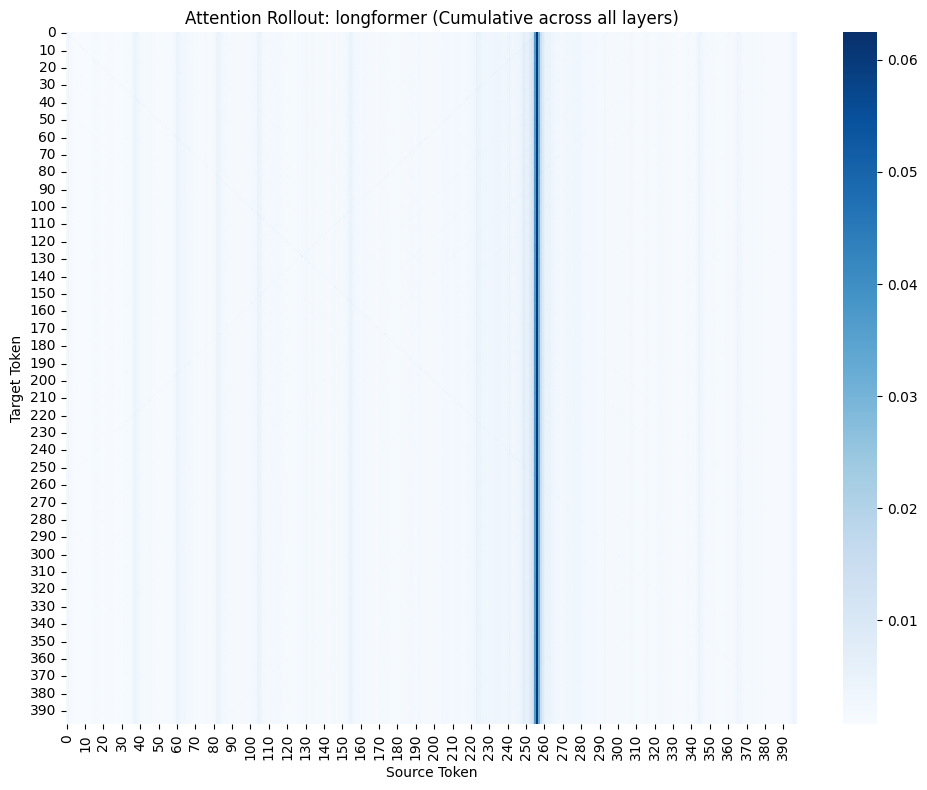

Step: Computed attention rollout across 12 layers (cropped to 398 tokens)
Interpretation: Shows cumulative attention flow - how early tokens influence later processing.


In [174]:
def attention_rollout(attention_layers, head_fusion='mean'):
    """
    Compute attention rollout across layers.
    Handles layers with mismatched seq lengths by cropping to the common minimum.
    """
    if not attention_layers:
        return None

    # Fuse heads per layer
    layer_attns = []
    for layer_attn in attention_layers:
        # layer_attn: [batch, heads, seq_q, seq_k]
        arr = layer_attn[0]  # drop batch -> [heads, seq_q, seq_k]
        if head_fusion == 'mean':
            fused = arr.mean(axis=0)
        elif head_fusion == 'max':
            fused = arr.max(axis=0)
        elif head_fusion == 'min':
            fused = arr.min(axis=0)
        else:
            fused = arr.mean(axis=0)
        layer_attns.append(fused)

    # Crop all layer matrices to a common square size (minimum across layers)
    min_rows = min(m.shape[0] for m in layer_attns)
    min_cols = min(m.shape[1] for m in layer_attns)
    seq_len = min(min_rows, min_cols)
    layer_attns = [m[:seq_len, :seq_len] for m in layer_attns]

    # Add residual (identity) and renormalize rows
    residual_weight = 0.5
    for i in range(len(layer_attns)):
        mat = residual_weight * layer_attns[i] + (1 - residual_weight) * np.eye(seq_len)
        row_sums = mat.sum(axis=1, keepdims=True)
        layer_attns[i] = mat / (row_sums + 1e-9)

    # Multiply attention matrices across layers
    rollout = layer_attns[0]
    for i in range(1, len(layer_attns)):
        rollout = np.matmul(rollout, layer_attns[i])

    return rollout

# Compute rollout for first model
if attention_data:
    first_model = list(attention_data.keys())[0]
    attn_layers = attention_data[first_model]

    rollout_matrix = attention_rollout(attn_layers, head_fusion='mean')

    if rollout_matrix is None:
        print("No attention layers available for rollout.")
    else:
        plt.figure(figsize=(10, 8))
        sns.heatmap(rollout_matrix, cmap='Blues', cbar=True)
        plt.title(f"Attention Rollout: {first_model} (Cumulative across all layers)")
        plt.xlabel("Source Token")
        plt.ylabel("Target Token")
        plt.tight_layout()
        plt.show()

        print(f"Step: Computed attention rollout across {len(attn_layers)} layers (cropped to {rollout_matrix.shape[0]} tokens)")
        print("Interpretation: Shows cumulative attention flow - how early tokens influence later processing.")

### 4. Token Influence Analysis

Measure how much total attention each token receives from all other tokens. Helps identify key tokens like [CLS] or important entities.

Top 15 Most Influential Tokens (Layer 6):
  1. Token 256: 'âĢ' - Influence: 17.2041
  2. Token 257: 'Ŀ' - Influence: 14.9610
  3. Token 255: '.' - Influence: 14.7047
  4. Token 258: 'ĠThese' - Influence: 10.0513
  5. Token 254: 'Ġreport' - Influence: 9.6020
  6. Token 259: 'Ġbehaviors' - Influence: 6.6901
  7. Token 253: 'the' - Influence: 6.6557
  8. Token 252: 'ľ' - Influence: 5.2433
  9. Token 260: 'Ġemerge' - Influence: 4.6344
  10. Token 251: 'ĠâĢ' - Influence: 4.1343
  11. Token 250: 'Ġor' - Influence: 3.8146
  12. Token 261: 'Ġas' - Influence: 3.5462
  13. Token 249: 'Ŀ' - Influence: 3.4434
  14. Token 248: 'âĢ' - Influence: 3.0753
  15. Token 262: 'Ġthe' - Influence: 3.0106


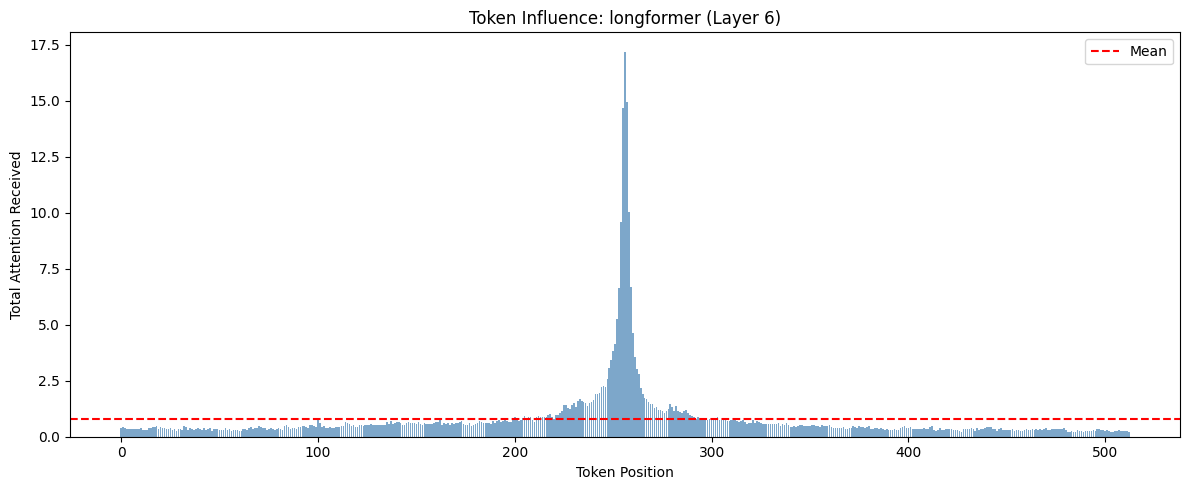


Interpretation: High-influence tokens act as information hubs that other tokens attend to.
['<s>', 'Large', 'Ġlanguage', 'Ġmodels', 'Ġ(', 'LL', 'Ms', ')', 'Ġlike', 'ĠG', 'PT', '-', '4', 'Ġor', 'ĠB', 'ERT', 'Ġoperate', 'Ġby', 'Ġusing', 'Ġa', 'Ġself', '-', 'att', 'ention', 'Ġmechanism', ',', 'Ġallowing', 'Ġevery', 'Ġword', 'Ġin', 'Ġa', 'Ġsentence', 'Ġto', 'Ġinteract', 'Ġwith', 'Ġevery', 'Ġother', 'Ġword', '.', 'ĠThis', 'Ġproperty', 'Ġenables', 'Ġmodels', 'Ġto', 'Ġunderstand', 'Ġcontext', ',', 'Ġdis', 'amb', 'ig', 'uate', 'Ġpronouns', ',', 'Ġand', 'Ġtie', 'Ġtogether', 'Ġrelationships', 'Ġthat', 'Ġspan', 'Ġmultiple', 'Ġsentences', '.', 'ĠIn', 'Ġshort', 'Ġtexts', ',', 'Ġthis', 'Ġmechanism', 'Ġhelps', 'Ġidentify', 'Ġpatterns', 'Ġlike', 'Ġadjective', '-', 'n', 'oun', 'Ġpair', 'ings', 'Ġor', 'Ġsubject', '-', 'verb', 'Ġalignment', '.', 'ĠBut', 'Ġin', 'Ġlonger', 'Ġdocuments', 'âĢĶ', 'such', 'Ġas', 'Ġacademic', 'Ġarticles', 'Ġor', 'Ġnews', 'Ġstories', 'âĢĶ', 'the', 'Ġrole', 'Ġof', 'Ġattention', 

In [176]:
# Token Influence: total attention received by each token
def compute_token_influence(attention_matrix):
    """
    Compute how much attention each token receives (column sums).
    Higher values = more influential tokens.
    """
    return attention_matrix.sum(axis=0)  # Sum across query dimension

if attention_data:
    first_model = list(attention_data.keys())[0]
    tok = tokenizers[first_model]
    
    # Get tokens
    inputs = tok(long_text, return_tensors='pt', truncation=True,
                 max_length=max_tokens[first_model])
    token_list = tok.convert_ids_to_tokens(inputs['input_ids'][0].tolist())
    
    # Compute influence for last layer, averaged across heads
    layer_idx = 6
    attn_last_layer = attention_data[first_model][layer_idx][0]  # [heads, seq, seq]
    avg_attn = attn_last_layer.mean(axis=0)  # Average across heads -> [seq, seq]
    
    token_influence = compute_token_influence(avg_attn)
    
    # Find top influential tokens
    top_k = 15
    top_indices = np.argsort(token_influence)[-top_k:][::-1]
    
    print(f"Top {top_k} Most Influential Tokens (Layer {layer_idx}):")
    for rank, idx in enumerate(top_indices, 1):
        if idx < len(token_list):
            print(f"  {rank}. Token {idx}: '{token_list[idx]}' - Influence: {token_influence[idx]:.4f}")
    
    # Visualize token influence
    plt.figure(figsize=(12, 5))
    plt.bar(range(len(token_influence)), token_influence, color='steelblue', alpha=0.7)
    plt.xlabel("Token Position")
    plt.ylabel("Total Attention Received")
    plt.title(f"Token Influence: {first_model} (Layer {layer_idx})")
    plt.axhline(y=token_influence.mean(), color='r', linestyle='--', label='Mean')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretation: High-influence tokens act as information hubs that other tokens attend to.")
    print(token_list)

### 5. Head Function Classification

Classify attention heads by their behavior patterns:
- **Local heads**: Focus on nearby tokens
- **Global heads**: Attend across long distances  
- **Positional bias heads**: Prefer specific positions (start/end)
- **Focused heads**: Low entropy (attend to few tokens)
- **Diffuse heads**: High entropy (spread attention broadly)

Head Classification for longformer:

 layer  head  q_len  k_len  avg_distance  entropy  first_token_bias  last_token_bias  diag_sum     type
     0     0    398    513    117.141048 2.707358      2.189693e-04     2.166171e-05  0.640348 Balanced
     0     1    398    513    127.102411 4.766181      2.744251e-04     2.227658e-04  0.968429  Diffuse
     0     2    398    513    179.435476 5.682176      7.717320e-04     7.458957e-04  0.592032  Diffuse
     0     3    398    513    171.540970 5.583121      7.926404e-04     6.591185e-04  0.730978  Diffuse
     0     4    398    513    164.617043 5.320142      5.521566e-04     5.016458e-04  0.727981  Diffuse
     0     5    398    513    130.327225 3.160115      2.282366e-04     9.218835e-05  0.673147 Balanced
     0     6    398    513    120.209132 2.993731      3.177403e-05     2.927660e-04  0.943622 Balanced
     0     7    398    513    183.909006 5.263002      9.290189e-04     9.095528e-04  0.525102  Diffuse
     0     8    398    513 

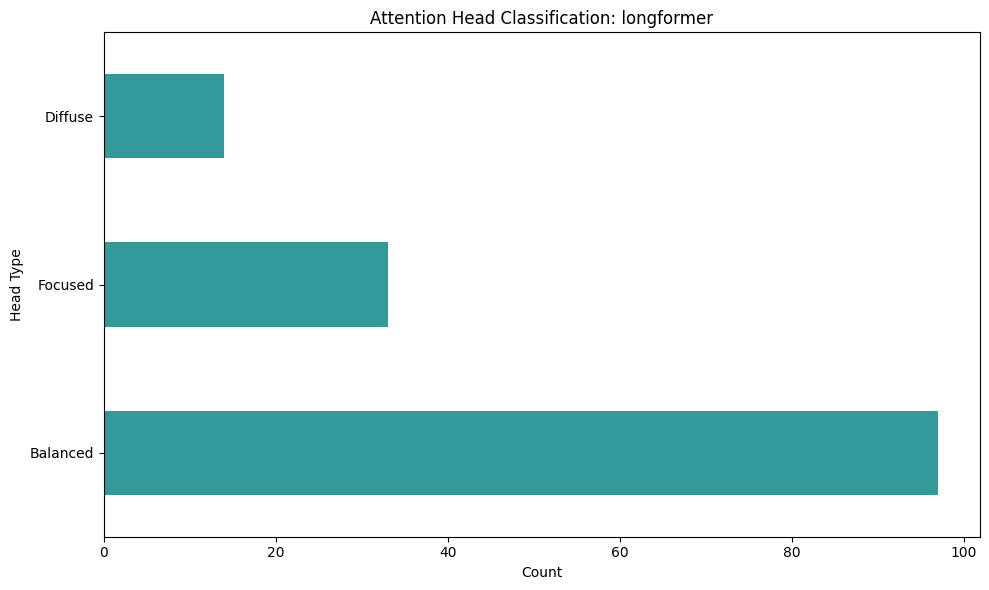


Interpretation:
- Local heads focus on nearby tokens (syntax, grammar)
- Global heads track long-range dependencies (coreference, themes)
- Focused heads attend to specific tokens (entities, keywords)
- Diffuse heads gather broad context


In [177]:
# Head Function Classification
def classify_attention_heads(attention_layers):
    """
    Classify each attention head by its behavior patterns.
    Returns a list of dicts with head classifications.
    Handles non-square attention matrices (seq_q != seq_k) robustly.
    """
    classifications = []
    
    for layer_idx, layer_attn in enumerate(attention_layers):
        # layer_attn shape: [batch, heads, seq_q, seq_k]
        num_heads = layer_attn.shape[1]
        
        for head_idx in range(num_heads):
            attn = layer_attn[0, head_idx]  # [seq_q, seq_k]
            q_len, k_len = attn.shape
            
            # Metric 1: Average attention distance (use per-query/key distances)
            q_idx = np.arange(q_len)[:, None]    # shape [q_len, 1]
            k_idx = np.arange(k_len)[None, :]    # shape [1, k_len]
            distances = np.abs(q_idx - k_idx)    # shape [q_len, k_len]
            total_attn = attn.sum()
            if total_attn <= 0:
                avg_distance = 0.0
            else:
                avg_distance = (attn * distances).sum() / (total_attn + 1e-12)
            
            # Metric 2: Entropy (spread of attention) - per-query entropy then mean
            entropies = scipy.stats.entropy(attn + 1e-12, axis=1)  # shape [q_len]
            avg_entropy = float(np.nanmean(entropies))
            
            # Metric 3: Positional bias (attention to first/last tokens) on key side
            first_token_attn = float(attn[:, 0].mean()) if k_len > 0 else 0.0
            last_token_attn = float(attn[:, -1].mean()) if k_len > 0 else 0.0
            
            # Metric 4: Diagonal concentration (local attention) - sum over min diag
            min_len = min(q_len, k_len)
            if min_len > 0:
                diagonal_sum = float(np.trace(attn[:min_len, :min_len]))
            else:
                diagonal_sum = 0.0
            
            # Classify based on metrics
            head_type = []
            seq_ref = max(q_len, k_len)
            if avg_distance < seq_ref * 0.15:
                head_type.append("Local")
            elif avg_distance > seq_ref * 0.4:
                head_type.append("Global")
            
            if avg_entropy < 2.5:
                head_type.append("Focused")
            elif avg_entropy > 4.5:
                head_type.append("Diffuse")
            
            if first_token_attn > 0.15:
                head_type.append("Start-Biased")
            if last_token_attn > 0.15:
                head_type.append("End-Biased")
            
            if not head_type:
                head_type.append("Balanced")
            
            classifications.append({
                'layer': int(layer_idx),
                'head': int(head_idx),
                'q_len': int(q_len),
                'k_len': int(k_len),
                'avg_distance': float(avg_distance),
                'entropy': float(avg_entropy),
                'first_token_bias': float(first_token_attn),
                'last_token_bias': float(last_token_attn),
                'diag_sum': float(diagonal_sum),
                'type': ', '.join(head_type)
            })
    
    return classifications

# Classify heads for first model
if attention_data:
    import pandas as pd
    
    first_model = list(attention_data.keys())[0]
    classifications = classify_attention_heads(attention_data[first_model])
    df = pd.DataFrame(classifications)
    
    print(f"Head Classification for {first_model}:\n")
    print(df.to_string(index=False))
    
    # Visualize head types
    type_counts = df['type'].value_counts()
    
    plt.figure(figsize=(10, 6))
    type_counts.plot(kind='barh', color='teal', alpha=0.8)
    plt.xlabel("Count")
    plt.ylabel("Head Type")
    plt.title(f"Attention Head Classification: {first_model}")
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretation:")
    print("- Local heads focus on nearby tokens (syntax, grammar)")
    print("- Global heads track long-range dependencies (coreference, themes)")
    print("- Focused heads attend to specific tokens (entities, keywords)")
    print("- Diffuse heads gather broad context")

### 6. Interactive Token Exploration with BertViz

BertViz provides interactive visualization to explore attention from any token. Click on tokens to see what they attend to!

In [181]:
# ...existing code...
# Interactive attention visualization with BertViz
from bertviz import head_view, model_view

if attention_data:
    first_model = list(attention_data.keys())[0]
    model = models[first_model]
    tokenizer = tokenizers[first_model]
    
    # Use a shorter text snippet for BertViz (more readable)
    short_text = sentences[0] if 'sentences' in locals() and sentences else long_text[:500]
    
    print(f"Preparing BertViz visualization for: '{short_text[:100]}...'")
    
    # Tokenize
    inputs = tokenizer(short_text, return_tensors='pt', truncation=True, max_length=512)
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    
    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    # Convert attention to format BertViz expects (torch tensors on CPU) and crop to token length
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    seq_len = len(tokens)
    
    attention_tensors = []
    for a in outputs.attentions:
        at = a.detach().cpu()  # keep as torch.Tensor for bertviz
        if at.dim() == 4:
            # crop to available token length (handle non-square/mismatched sizes)
            r = min(at.shape[2], seq_len)
            c = min(at.shape[3], seq_len)
            at = at[:, :, :r, :c]
        attention_tensors.append(at)
    
    # Head view: interactive exploration
    print("\nGenerating head view (shows attention from each head)...")
    head_view(attention_tensors, tokens)
    
    print("\nGenerating model view (shows attention across all layers)...")
    model_view(attention_tensors, tokens)
    
    print("\nStep: Interactive visualizations generated")
    print("Use the controls to explore different layers, heads, and tokens!")
# ...existing code...

Preparing BertViz visualization for: '<s>Large language models (LLMs) like GPT-4 or BERT operate by using a self-attention mechanism, allo...'

Generating head view (shows attention from each head)...


<IPython.core.display.Javascript object>


Generating model view (shows attention across all layers)...


<IPython.core.display.Javascript object>


Step: Interactive visualizations generated
Use the controls to explore different layers, heads, and tokens!


### 7. Comparative Analysis Across Models

Compare how different models (BERT, Longformer, BigBird) handle the same long document using our quantitative metrics.

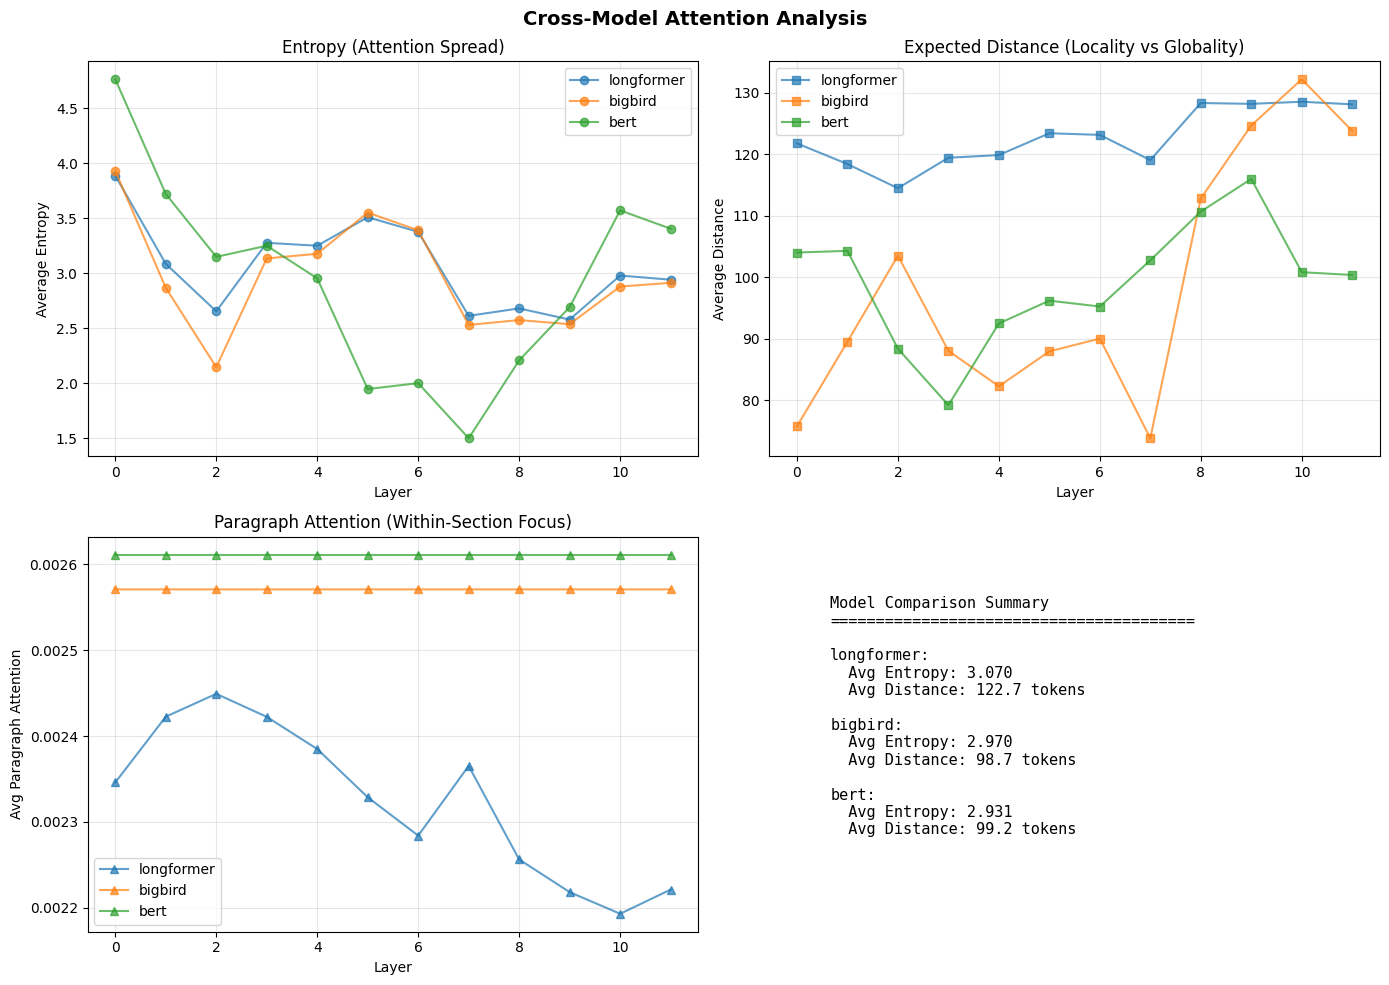

Step: Compared attention patterns across models

Interpretation:
- Higher entropy = more diffuse attention
- Higher distance = more global, long-range attention
- Longformer/BigBird should show different patterns than BERT on long docs


In [182]:
# Comparative analysis across models
if len(metrics) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    for model_key in metrics:
        met = metrics[model_key]
        n_layers = len(met['entropy'])
        
        # Average across heads for each layer
        avg_entropy = [np.mean(layer) for layer in met['entropy']]
        avg_distance = [np.mean(layer) for layer in met['exp_dist']]
        avg_para_attn = [np.mean(layer) for layer in met['para_attn']]
        
        # Plot metrics
        axes[0, 0].plot(avg_entropy, marker='o', label=model_key, alpha=0.7)
        axes[0, 1].plot(avg_distance, marker='s', label=model_key, alpha=0.7)
        axes[1, 0].plot(avg_para_attn, marker='^', label=model_key, alpha=0.7)
    
    axes[0, 0].set_title("Entropy (Attention Spread)")
    axes[0, 0].set_xlabel("Layer")
    axes[0, 0].set_ylabel("Average Entropy")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title("Expected Distance (Locality vs Globality)")
    axes[0, 1].set_xlabel("Layer")
    axes[0, 1].set_ylabel("Average Distance")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_title("Paragraph Attention (Within-Section Focus)")
    axes[1, 0].set_xlabel("Layer")
    axes[1, 0].set_ylabel("Avg Paragraph Attention")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Summary table
    axes[1, 1].axis('off')
    summary_text = "Model Comparison Summary\n" + "="*40 + "\n\n"
    
    for model_key in metrics:
        met = metrics[model_key]
        avg_ent = np.mean([np.mean(layer) for layer in met['entropy']])
        avg_dist = np.mean([np.mean(layer) for layer in met['exp_dist']])
        summary_text += f"{model_key}:\n"
        summary_text += f"  Avg Entropy: {avg_ent:.3f}\n"
        summary_text += f"  Avg Distance: {avg_dist:.1f} tokens\n\n"
    
    axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace', 
                    verticalalignment='center')
    
    plt.suptitle("Cross-Model Attention Analysis", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("Step: Compared attention patterns across models")
    print("\nInterpretation:")
    print("- Higher entropy = more diffuse attention")
    print("- Higher distance = more global, long-range attention")
    print("- Longformer/BigBird should show different patterns than BERT on long docs")
else:
    print("Only one model loaded - skipping comparative analysis")